<a href="https://colab.research.google.com/github/EvergreenTree/MVA_Deeplearning/blob/master/MVA_MP1_FU_Changqing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
# My Intel Graphic card not supported by CUDA, so I tried Google Cloud VM, but GPU 
# usage was not permitted. At last I used google colab for GPU acceleration.

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11163925059973029417
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10436302181681167715
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7466361387879743045
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281553818
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9758926680751762472
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


# Preparation

In [3]:
# data generation functions from mp1.py
import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *


def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if (i+1) % 100 == 0:
            print(i+1)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification(nb_samples):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(nb_samples, 20, True)
    Y_test = keras.utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if (i+1) % 100 == 0:
            print(i+1)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y, yp=[]):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((72,72))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)
    
    if yp != []:
        xyp = yp.reshape(3,2)
        tri2 = patches.Polygon(xyp, closed=True, fill = False, edgecolor = 'g', linewidth = 5, alpha = 0.5)
        ax.add_patch(tri2)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]



Using TensorFlow backend.


In [0]:
import tensorflow as tf

Creating data:
100
200
300


Text(0.5,1,'label = [0. 0. 1.] X_train.shape = (300, 5184)')

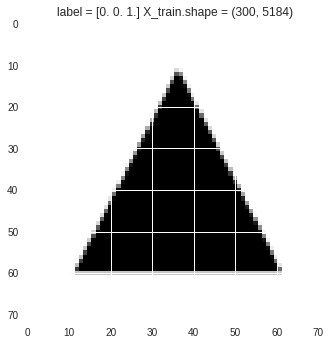

In [2]:
[X_train, Y_train] = generate_dataset_classification(nb_samples=300, noise=0., free_location=False)
Y_train=keras.utils.to_categorical(Y_train)
# 0 = square, 1 = disk, 2 = triangle
k=20
# X_train=X_train.reshape(-1,5184)
plt.imshow(X_train[k,:].reshape(72,72), cmap='gray')
plt.title("label = "+str(Y_train[k])+" X_train.shape = " +str(X_train.shape))
# plotting a template training data


Creating data:


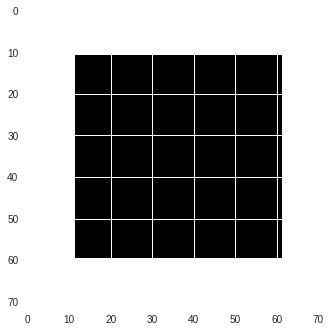

In [3]:
X_test, Y_test = generate_dataset_classification(1)
X_test = X_test.reshape(-1, 5184)
plt.imshow(X_test[0].reshape(72,72), cmap='gray')
# making a test data

# First Model


In [0]:

# All parameter gradients will be clipped to a maximum norm of 1.

# sgd = optimizers.SGD(lr=0.01, clipnorm=1.)
sgd = SGD(lr=0.01,
          decay=1e-6, momentum=0.9, clipnorm=1.,
          nesterov=True)

model = Sequential()
model.add(Dense(units=256, activation='relu',input_shape=(5184,)))
# model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units=3, activation='sigmoid'))
# model.add(BatchNormalization())
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
# define model

In [5]:
# from keras.initializers import glorot_uniform  # Or your initializer of choice
# initial_weights = model.get_weights()
# new_weights = [glorot_uniform()(w.shape) for w in initial_weights]
# model.set_weights(new_weights)
# clear weights
model.fit(X_train, Y_train, epochs=40, batch_size=128)
# fit model

Epoch 1/40
300/300 [==============================] - 1s 2ms/step - loss: 1.4165 - acc: 0.3500
Epoch 2/40
300/300 [==============================] - 0s 219us/step - loss: 1.0973 - acc: 0.3733
Epoch 3/40
300/300 [==============================] - 0s 237us/step - loss: 1.0726 - acc: 0.4067
Epoch 4/40
300/300 [==============================] - 0s 241us/step - loss: 1.0032 - acc: 0.3400
Epoch 5/40
300/300 [==============================] - 0s 216us/step - loss: 0.9600 - acc: 0.3933
Epoch 6/40
300/300 [==============================] - 0s 221us/step - loss: 0.9152 - acc: 0.4100
Epoch 7/40
300/300 [==============================] - 0s 208us/step - loss: 0.8727 - acc: 0.3800
Epoch 8/40
300/300 [==============================] - 0s 215us/step - loss: 0.8528 - acc: 0.4267
Epoch 9/40
300/300 [==============================] - 0s 211us/step - loss: 0.7809 - acc: 0.5600
Epoch 10/40
300/300 [==============================] - 0s 208us/step - loss: 0.7075 - acc: 0.6833
Epoch 11/40
300/300 [==========

In [6]:
model.predict(X_test)
# test a prediction (it works)

array([[4.4648815e-02, 5.9911974e-05, 3.6739853e-05]], dtype=float32)

In [7]:
model.summary()
# showing size of layers

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               1327360   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 1,328,131
Trainable params: 1,328,131
Non-trainable params: 0
_________________________________________________________________


# Free Location

In [8]:
[X_train, Y_train] = generate_dataset_classification(2000, 20, free_location=True)
Y_train=keras.utils.to_categorical(Y_train,num_classes=3)
# another training data: free location 

Creating data:
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [12]:
[X_test, Y_test] = generate_test_set_classification(2000)
# test data (centered)

Creating data:
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [9]:
Y_train.shape, X_train.shape

((2000, 3), (2000, 5184))

In [14]:
model.fit(X_train, Y_train, epochs=40, batch_size=128)
#re-run several times or set batch_size as large numbers

Epoch 1/40
2000/2000 [==============================] - 0s 194us/step - loss: 0.7332 - acc: 0.6255
Epoch 2/40
2000/2000 [==============================] - 0s 183us/step - loss: 0.7103 - acc: 0.6310
Epoch 3/40
2000/2000 [==============================] - 0s 189us/step - loss: 0.7191 - acc: 0.6210
Epoch 4/40
2000/2000 [==============================] - 0s 185us/step - loss: 0.7218 - acc: 0.6325
Epoch 5/40
2000/2000 [==============================] - 0s 181us/step - loss: 0.7104 - acc: 0.6325
Epoch 6/40
2000/2000 [==============================] - 0s 191us/step - loss: 0.7218 - acc: 0.6390
Epoch 7/40
2000/2000 [==============================] - 0s 233us/step - loss: 0.7144 - acc: 0.6340
Epoch 8/40
2000/2000 [==============================] - 0s 238us/step - loss: 0.7185 - acc: 0.6300
Epoch 9/40
2000/2000 [==============================] - 0s 235us/step - loss: 0.7138 - acc: 0.6275
Epoch 10/40
2000/2000 [==============================] - 0s 233us/step - loss: 0.6974 - acc: 0.6440
Epoch 11/

In [15]:
[i for i in zip(model.metrics_names,model.evaluate(X_test, Y_test))]
# interpretation of the above quantities, meaning that outcome is not as good, since the model may learn the position

2000/2000 [==============================] - 0s 115us/step


[('loss', 0.6758294506072998), ('acc', 0.658)]

# Second Model - CNN


In [0]:
X_train_img=X_train.reshape(-1,1,72,72)
X_test_img=X_test.reshape(-1,1,72,72)

In [0]:

model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu',
          input_shape=(1,72,72),data_format='channels_first'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# define a better model

In [18]:
[i for i in map(np.shape,model.get_weights())]

[(5, 5, 1, 32), (32,), (36992, 128), (128,), (128, 3), (3,)]

In [19]:
model.fit(X_train_img, Y_train, batch_size=32, epochs=10, verbose=1)

Epoch 1/10
2000/2000 [==============================] - 45s 22ms/step - loss: 1.4260 - acc: 0.5235
Epoch 2/10
2000/2000 [==============================] - 44s 22ms/step - loss: 0.6897 - acc: 0.6990
Epoch 3/10
2000/2000 [==============================] - 44s 22ms/step - loss: 0.5838 - acc: 0.7555
Epoch 4/10
2000/2000 [==============================] - 44s 22ms/step - loss: 0.4889 - acc: 0.8115
Epoch 5/10
2000/2000 [==============================] - 44s 22ms/step - loss: 0.3794 - acc: 0.8750
Epoch 6/10
2000/2000 [==============================] - 44s 22ms/step - loss: 0.2737 - acc: 0.9085
Epoch 7/10
2000/2000 [==============================] - 44s 22ms/step - loss: 0.2159 - acc: 0.9310
Epoch 8/10
2000/2000 [==============================] - 44s 22ms/step - loss: 0.1614 - acc: 0.9550
Epoch 9/10
2000/2000 [==============================] - 44s 22ms/step - loss: 0.1244 - acc: 0.9660
Epoch 10/10
2000/2000 [==============================] - 44s 22ms/step - loss: 0.1083 - acc: 0.9690


In [20]:
model.evaluate(X_test_img, Y_test)
# large epochs will cause overfitting

2000/2000 [==============================] - 27s 13ms/step


[0.3654655305147171, 0.865]

# Regression Model


Creating data:
100
200
300
400
500
600
700
800
900
1000
Creating data:
100
200
300
400
500
600
700
800
900
1000


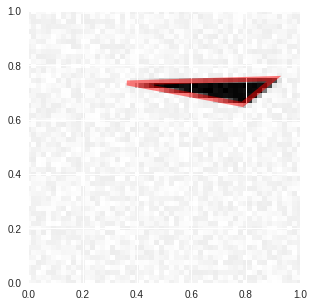

In [3]:
[X_train_reg, Y_train_reg] = generate_dataset_regression(1000, 20)
[X_test_reg, Y_test_reg] = generate_dataset_regression(1000, 20)
visualize_prediction(X_train_reg[0], Y_train_reg[0])

In [0]:
X_train_reg_img=X_train_reg.reshape(-1,1,72,72)
X_test_reg_img=X_test_reg.reshape(-1,1,72,72)

In [0]:

model = Sequential([
        Flatten(input_shape=(1,72,72),data_format='channels_first'),
        Dense(200, activation='relu'),
        Dropout(0.2), 
        Dense(200, activation='relu'),
        Dropout(0.2), 
        Dense(200, activation='relu'),
        Dropout(0.2), 
        Dense(6)
    ])
model.compile('adadelta', 'mse')

In [9]:
model.fit(X_train_reg_img, Y_train_reg, batch_size=32, epochs=200, verbose=1)

Epoch 1/200
1000/1000 [==============================] - 1s 615us/step - loss: 0.7189
Epoch 2/200
1000/1000 [==============================] - 0s 278us/step - loss: 0.1544
Epoch 3/200
1000/1000 [==============================] - 0s 290us/step - loss: 0.1654
Epoch 4/200
1000/1000 [==============================] - 0s 273us/step - loss: 0.0944
Epoch 5/200
1000/1000 [==============================] - 0s 267us/step - loss: 0.0869
Epoch 6/200
1000/1000 [==============================] - 0s 273us/step - loss: 0.0866
Epoch 7/200
1000/1000 [==============================] - 0s 279us/step - loss: 0.0861
Epoch 8/200
1000/1000 [==============================] - 0s 272us/step - loss: 0.0866
Epoch 9/200
1000/1000 [==============================] - 0s 268us/step - loss: 0.0860
Epoch 10/200
1000/1000 [==============================] - 0s 272us/step - loss: 0.0858
Epoch 11/200
1000/1000 [==============================] - 0s 273us/step - loss: 0.0856
Epoch 12/200
1000/1000 [============================

In [10]:
model.evaluate(X_test_reg_img, Y_test_reg)

1000/1000 [==============================] - 0s 142us/step


0.08297324752807617

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:129: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


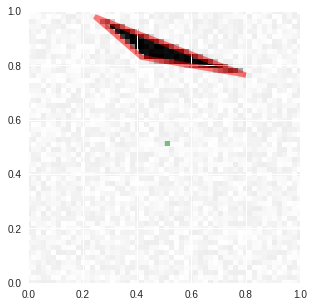

In [11]:
t=30
X_predict=X_test_reg[t].reshape(-1,5184)
Y_true=Y_test_reg[t]
Y_predict=model.predict(X_test_reg_img[t].reshape(-1,1,72,72))
visualize_prediction(X_predict, Y_true, Y_predict)
# Not working, trying other methods
# notice that green line is the prediction result

# Normalize Y

In [0]:
def nml(z):
    z=z.reshape(-1,3,2)
    for i in range(z.shape[0]):
        if np.cross(z[i,2]-z[i,0],z[i,1]-z[i,0])>0:
            z[i]=z[i,[0, 2, 1]]
    return z.reshape(-1,6)

Y_train_reg=nml(Y_train_reg)
Y_test_reg=nml(Y_test_reg)
# arranging data clockwise

In [0]:
sgd = SGD(lr=0.01,
          decay=1e-6, momentum=0.9, clipnorm=1.,
          nesterov=True)
model = Sequential([
        Flatten(input_shape=(1,72,72),data_format='channels_first'),
        Dense(200, activation='relu'),
        Dropout(0.2), 
        Dense(6)
    ])
model.compile(sgd, 'mse')

In [15]:
model.fit(X_train_reg_img, Y_train_reg, batch_size=32, epochs=200, verbose=1)
# training could be run several times
# 

Epoch 1/200
1000/1000 [==============================] - 0s 190us/step - loss: 0.0672
Epoch 2/200
1000/1000 [==============================] - 0s 178us/step - loss: 0.0672
Epoch 3/200
1000/1000 [==============================] - 0s 193us/step - loss: 0.0677
Epoch 4/200
1000/1000 [==============================] - 0s 188us/step - loss: 0.0676
Epoch 5/200
1000/1000 [==============================] - 0s 183us/step - loss: 0.0671
Epoch 6/200
1000/1000 [==============================] - 0s 181us/step - loss: 0.0669
Epoch 7/200
1000/1000 [==============================] - 0s 182us/step - loss: 0.0665
Epoch 8/200
1000/1000 [==============================] - 0s 184us/step - loss: 0.0671
Epoch 9/200
1000/1000 [==============================] - 0s 185us/step - loss: 0.0678
Epoch 10/200
1000/1000 [==============================] - 0s 182us/step - loss: 0.0679
Epoch 11/200
1000/1000 [==============================] - 0s 179us/step - loss: 0.0678
Epoch 12/200
1000/1000 [============================

In [16]:
model.evaluate(X_test_reg_img, Y_test_reg)

1000/1000 [==============================] - 0s 140us/step


0.06970112669467926

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:129: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


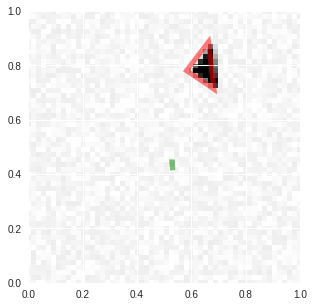

In [17]:
t=40
X_predict=X_test_reg[t].reshape(-1,5184)
Y_true=Y_test_reg[t]
Y_predict=model.predict(X_test_reg_img[t].reshape(-1,1,72,72))
visualize_prediction(X_predict, Y_true, Y_predict)
# Not working, trying other methods
# notice that green line is the prediction result

# Another Model

In [0]:
model = Sequential([
        Conv2D(64, (3, 3), strides=(1,1),activation='relu',padding='same',input_shape=(1,72,72),data_format='channels_first'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Conv2D(16, (3, 3), strides=(1,1), activation='relu',padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Conv2D(16, (3, 3), strides=(1,1), activation='relu',padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Conv2D(16, (3, 3), strides=(1,1), activation='relu',padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Conv2D(16, (3, 3), strides=(1,1), activation='relu',padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Conv2D(16, (3, 3), strides=(1,1), activation='relu',padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Flatten(),
        Dropout(0.2), 
        Dense(256, activation='relu'),
        Dropout(0.2), 
        Dense(64, activation='relu'),
        Dropout(0.2), 
        Dense(6)
    ])
model.compile(Adam(lr=1e-3), 'mse')

In [21]:
model.fit(X_train_reg_img, Y_train_reg, batch_size=32, epochs=200, verbose=1)

Epoch 1/200
1000/1000 [==============================] - 1s 982us/step - loss: 0.0696
Epoch 2/200
1000/1000 [==============================] - 1s 907us/step - loss: 0.0696
Epoch 3/200
1000/1000 [==============================] - 1s 903us/step - loss: 0.0682
Epoch 4/200
1000/1000 [==============================] - 1s 883us/step - loss: 0.0684
Epoch 5/200
1000/1000 [==============================] - 1s 890us/step - loss: 0.0687
Epoch 6/200
1000/1000 [==============================] - 1s 889us/step - loss: 0.0681
Epoch 7/200
1000/1000 [==============================] - 1s 881us/step - loss: 0.0669
Epoch 8/200
1000/1000 [==============================] - 1s 876us/step - loss: 0.0668
Epoch 9/200
1000/1000 [==============================] - 1s 884us/step - loss: 0.0663
Epoch 10/200
1000/1000 [==============================] - 1s 888us/step - loss: 0.0666
Epoch 11/200
1000/1000 [==============================] - 1s 875us/step - loss: 0.0659
Epoch 12/200
1000/1000 [============================

In [0]:
# model.save('dncnn5.h5')
# from keras.models import load_model
# model = load_model('dncnn5.h5')
# to avoid repeated training, model can be saved

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:129: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


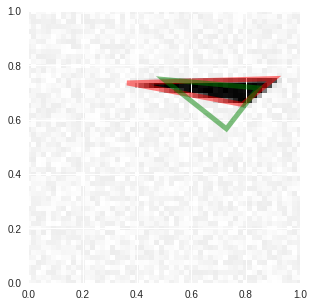

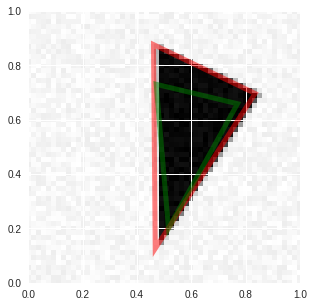

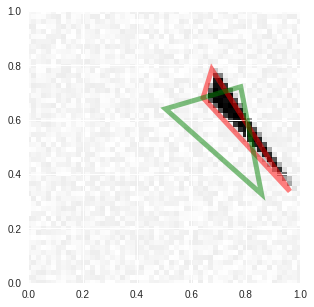

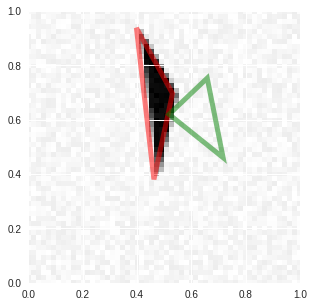

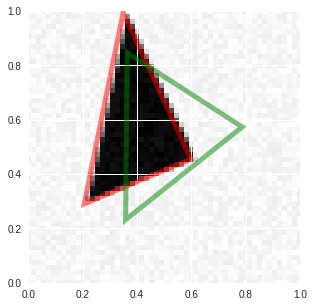

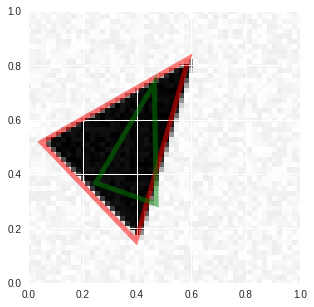

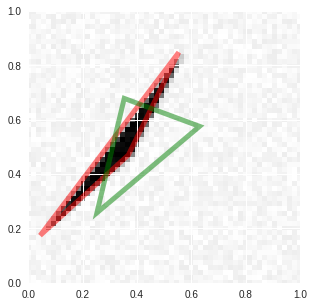

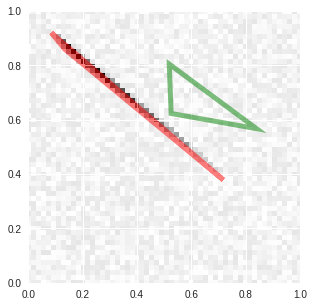

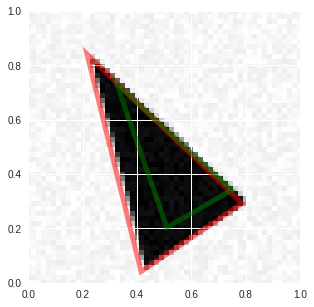

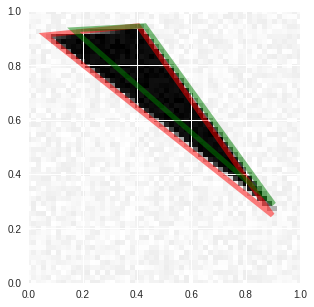

In [22]:
for i in range(10):
#     plt.subplot(5, 6, i + 1)
    X_predict=X_train_reg_img[i].reshape(-1,5184)
    Y_true=Y_train_reg[i]
    Y_predict=model.predict(X_predict.reshape(-1,1,72,72))
    visualize_prediction(X_predict, Y_true, yp=Y_predict)
    

# Denoise

In [0]:
def generate_two_triangles(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    imdata0 = generate_a_drawing(figsize, U, V, 0)
    return [imdata, imdata0]

def generate_dataset_denoise(nb_samples, noise=20.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if (i+1) % 100 == 0:
            print(i+1)
        [X[i], Y[i]] = generate_two_triangles(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def visualize_denoise_prediction(K, x, y):
    for i in range(K):
        plt.subplots(K,2,2*i+1)
        plt.imshow(x[i].reshape(72,72),cmap='gray')
        plt.subplots(K,2,2*i+2)
        plt.imshow(y[i].reshape(72,72),cmap='gray')
    
      

In [20]:
X_train_den, Y_train_den = generate_dataset_denoise(3000,20)

Creating data:
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000


In [19]:
X_test_den, Y_test_den = generate_dataset_denoise(3000,20)

Creating data:
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000


In [0]:
X_train_den_img=X_train_den.reshape(-1,1,72,72)
X_test_den_img=X_test_den.reshape(-1,1,72,72)
Y_train_den_img=Y_train_den.reshape(-1,1,72,72)
Y_test_den_img=Y_test_den.reshape(-1,1,72,72)

In [28]:
sgd = SGD(lr=0.01,
          decay=1e-6, momentum=0.9, clipnorm=1.,
          nesterov=True)

model = Sequential([
#         Conv2D(16, (3, 3), strides=(1,1),activation='relu',padding='same',input_shape=(1,72,72),data_format='channels_first'),
#         MaxPooling2D(pool_size=(2, 2)),
#         BatchNormalization(),
#         Conv2D(16, (3, 3), strides=(1,1), activation='relu',padding='same'),
#         MaxPooling2D(pool_size=(2, 2)),
#         BatchNormalization(),
#         Conv2D(16, (3, 3), strides=(1,1), activation='relu',padding='same'),
#         MaxPooling2D(pool_size=(2, 2)),
#         BatchNormalization(),
        Flatten(input_shape=(1,72,72),data_format='channels_first'),
        Dense(64, activation='relu'),
        Dense(16, activation='relu'),
        Dense(16, activation='relu'),
        Dense(16, activation='relu'),
        Dense(16, activation='relu'),
        Dense(16, activation='relu'),
        Dense(64, activation='relu'),
        Dense(5184)
    ])
model.compile('adam', 'mse')
model.fit(X_train_den_img, Y_test_den, batch_size=32, epochs=200, verbose=1)

Epoch 1/200
1000/1000 [==============================] - 1s 917us/step - loss: 52108.4693
Epoch 2/200
1000/1000 [==============================] - 0s 334us/step - loss: 4676.9230
Epoch 3/200
1000/1000 [==============================] - 0s 328us/step - loss: 2382.7482
Epoch 4/200
1000/1000 [==============================] - 0s 316us/step - loss: 2288.4997
Epoch 5/200
1000/1000 [==============================] - 0s 314us/step - loss: 2279.2061
Epoch 6/200
1000/1000 [==============================] - 0s 309us/step - loss: 2276.8983
Epoch 7/200
1000/1000 [==============================] - 0s 330us/step - loss: 2270.5667
Epoch 8/200
1000/1000 [==============================] - 0s 307us/step - loss: 2271.7831
Epoch 9/200
1000/1000 [==============================] - 0s 310us/step - loss: 2270.5902
Epoch 10/200
1000/1000 [==============================] - 0s 305us/step - loss: 2263.5611
Epoch 11/200
1000/1000 [==============================] - 0s 315us/step - loss: 2261.4138
Epoch 12/200
1000/

In [29]:
model.evaluate(X_test_den_img, Y_test_den)

1000/1000 [==============================] - 0s 224us/step


2205.494970703125

In [0]:
Y_predict_den=model.predict(X_test_den_img)

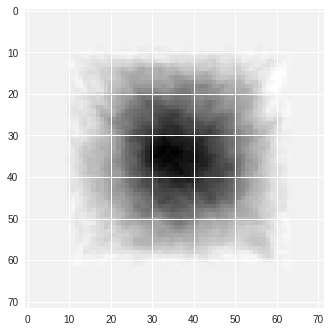

In [31]:
plt.imshow(Y_predict_den[1].reshape(72,72),cmap='gray')
# same method failed

# Hourglass model for denoising

In [0]:
keras.backend.set_image_data_format('channels_first')
input_img = Input(shape=(1,72,72))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mse')

In [60]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 1, 72, 72)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 32, 72, 72)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 36, 36)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 36, 36)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 18, 18)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 32, 18, 18)        9248      
_________________________________________________________________
up_sampling2d_9 (UpSampling2 (None, 32, 36, 36)        0         
__________

In [66]:
autoencoder.fit(X_train_den_img, Y_train_den_img,
                epochs=50,
                batch_size=8,
                shuffle=True,
                validation_data=(X_test_den_img, Y_test_den_img),
#                 callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)]
               )

Train on 1000 samples, validate on 1000 samples
Epoch 1/50
1000/1000 [==============================] - 2s 2ms/step - loss: 61491.8352 - val_loss: 61630.1503
Epoch 2/50
1000/1000 [==============================] - 2s 2ms/step - loss: 61491.8353 - val_loss: 61630.1503
Epoch 3/50
1000/1000 [==============================] - 2s 2ms/step - loss: 61491.8350 - val_loss: 61630.1503
Epoch 4/50
1000/1000 [==============================] - 2s 2ms/step - loss: 61491.8349 - val_loss: 61630.1503
Epoch 5/50
1000/1000 [==============================] - 2s 2ms/step - loss: 61491.8352 - val_loss: 61630.1503
Epoch 6/50
1000/1000 [==============================] - 2s 2ms/step - loss: 61491.8350 - val_loss: 61630.1503
Epoch 7/50
1000/1000 [==============================] - 2s 2ms/step - loss: 61491.8349 - val_loss: 61630.1503
Epoch 8/50
 968/1000 [============================>.] - ETA: 0s - loss: 61509.5505

KeyboardInterrupt: ignored

In [67]:
autoencoder.evaluate(X_test_den_img, Y_test_den_img)

1000/1000 [==============================] - 0s 276us/step


61630.1503125

In [0]:
Y_predict_den=autoencoder.predict(X_test_den_img)

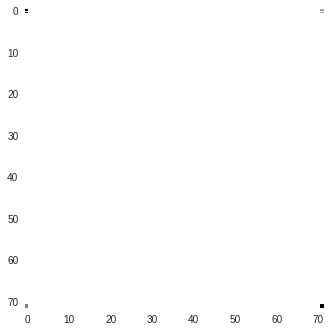

In [69]:
plt.imshow(Y_predict_den[1].reshape(72,72),cmap='gray')
# hourglass net failed

# CNN model for denoising

In [35]:
keras.backend.set_image_data_format('channels_first')
model_input = Input(shape=(1, 72, 72))
x = Conv2D(16, (3, 3), strides=(1,1), padding="same")(model_input)
x = Activation("relu")(x)
for i in range(10):
    x = Conv2D(16, (3, 3), strides=(1,1), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
x = Conv2D(1, (3, 3), strides=(1,1), padding="same")(x)
x = Subtract()([model_input, x]) # input - noise
    
model = Model(model_input, x)
model.compile(optimizer=Adam(lr=.05), loss='mse')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 1, 72, 72)    0                                            
__________________________________________________________________________________________________
conv2d_116 (Conv2D)             (None, 16, 72, 72)   160         input_13[0][0]                   
__________________________________________________________________________________________________
activation_107 (Activation)     (None, 16, 72, 72)   0           conv2d_116[0][0]                 
__________________________________________________________________________________________________
conv2d_117 (Conv2D)             (None, 16, 72, 72)   2320        activation_107[0][0]             
__________________________________________________________________________________________________
activation

In [36]:
model.fit(X_train_den_img, Y_train_den_img,
                epochs=200,
                batch_size=64,
                shuffle=True,
                validation_data=(X_test_den_img, Y_test_den_img),
#                 callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)]
               )

Train on 3000 samples, validate on 3000 samples
Epoch 1/200
3000/3000 [==============================] - 16s 5ms/step - loss: 14099.1899 - val_loss: 24007.0177
Epoch 2/200
3000/3000 [==============================] - 10s 3ms/step - loss: 573.1887 - val_loss: 10162.2898
Epoch 3/200
3000/3000 [==============================] - 10s 3ms/step - loss: 398.9386 - val_loss: 14174.9391
Epoch 4/200
3000/3000 [==============================] - 10s 3ms/step - loss: 302.3103 - val_loss: 11734.9724
Epoch 5/200
3000/3000 [==============================] - 10s 3ms/step - loss: 216.2658 - val_loss: 42794.9731
Epoch 6/200
3000/3000 [==============================] - 10s 3ms/step - loss: 146.0993 - val_loss: 36542.7795
Epoch 7/200
3000/3000 [==============================] - 10s 3ms/step - loss: 107.0311 - val_loss: 36950.2575
Epoch 8/200
3000/3000 [==============================] - 10s 3ms/step - loss: 74.9151 - val_loss: 37184.4684
Epoch 9/200
3000/3000 [==============================] - 10s 3ms/step -

KeyboardInterrupt: ignored

3000/3000 [==============================] - 3s 1ms/step


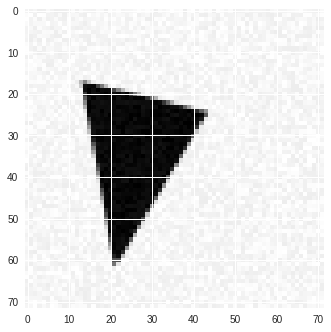

In [37]:
model.evaluate(X_test_den_img, Y_test_den_img)
Y_predict_den=model.predict(X_test_den_img)
plt.imshow(X_test_den_img[1].reshape(72,72),cmap='gray')
# image with noise

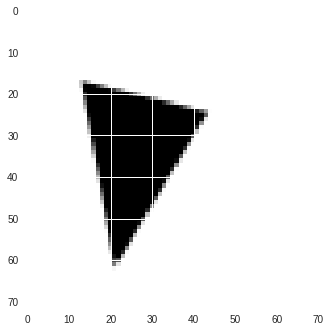

In [39]:
# image without noise
plt.imshow(Y_test_den_img[1].reshape(72,72),cmap='gray')

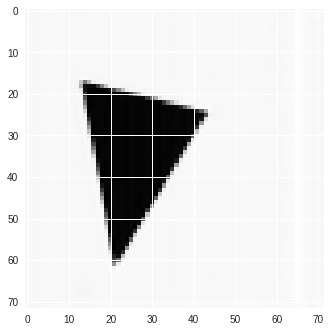

In [38]:
# denoise outcome
plt.imshow(Y_predict_den[1].reshape(72,72),cmap='gray')
# succeeded

Note that the convergence isn't stable: at some point (e.g. step 70) both training and validation loss increased. Since the outcome is good enough, I applied manual early stopping.